# Обучение классификатора с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [ ]:
!pip install datasets # для удобства работы с данными

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 7.8 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset

# https://www.nltk.org/api/nltk.tokenize.html?highlight=tokenize#module-nltk.tokenize
# https://www.nltk.org/api/nltk.tokenize.word_tokenize.html?highlight=word_tokenize#nltk.tokenize.word_tokenize
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотрим что из себя представляет датасет

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [ ]:
type(dataset['train']['text'])

list

In [ ]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
len(dataset['train']['text'])

25000

In [ ]:
# 0й элемент текста из листа
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
dataset['train']['label'][0]

0

### Подсчитаем частоту вхождения слов, чтобы составить словарь

Посмотрю что делают составляющие эл-ты фции ниже

In [ ]:
# пунктуация https://docs.python.org/3/library/string.html#string.punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
txt = "Hello Sam!"
# создание мапы для замены символов https://docs.python.org/3/library/stdtypes.html#str.maketrans
mytable = str.maketrans("", "", string.punctuation)
# замена одних символов на другие https://docs.python.org/3/library/stdtypes.html#str.translate
print(txt.translate(mytable))

Hello Sam


In [ ]:
# Токенизация с помощью либы NLTK и модуля tokenizer https://www.nltk.org/api/nltk.tokenize.html?highlight=tokenize#module-nltk.tokenize
word_tokenize('Ouch, what the f. I have many dogs')

['Ouch', ',', 'what', 'the', 'f.', 'I', 'have', 'many', 'dogs']

Теперь сам подсчет частоты вхождения слов

In [ ]:
# Сounter для подсчета  кол-ва вхождений ключа, а-ля словарь с доп функциями
# https://docs.python.org/3/library/collections.html#collections.Counter
words = Counter() 

# проходимся по списку тк dataset['train']['text'] - это список https://colab.research.google.com/drive/1BSKPq2HYOdTZ6horSv_GyTac30BcFg4A#scrollTo=OWF2bASRcNm4&line=1&uniqifier=1
for example in tqdm(dataset['train']['text']):

    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))
    
    # проходимся по словам, токенизируем их, токен добавляем в Counter 
    # для подсчета количества вхождений
    # https://www.nltk.org/api/nltk.tokenize.html?highlight=tokenize#module-nltk.tokenize
    for word in word_tokenize(prccessed_text):
        words[word] += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

То что получилось после подсчета токенов

In [ ]:
type(words)

collections.Counter

In [ ]:
# 10 самых частых исп слов из текстов
words.most_common(10)

[('the', 334696),
 ('and', 162228),
 ('a', 161941),
 ('of', 145326),
 ('to', 135042),
 ('is', 106855),
 ('in', 93028),
 ('it', 77109),
 ('i', 75732),
 ('this', 75190)]

In [ ]:
# длина словаря
len(words)

121222

In [ ]:
words

Counter({'i': 75732,
         'rented': 337,
         'am': 2769,
         'curiousyellow': 3,
         'from': 20392,
         'my': 12443,
         'video': 1547,
         'store': 477,
         'because': 8990,
         'of': 145326,
         'all': 23156,
         'the': 334696,
         'controversy': 49,
         'that': 69353,
         'surrounded': 133,
         'it': 77109,
         'when': 14087,
         'was': 48008,
         'first': 8857,
         'released': 944,
         'in': 93028,
         '1967': 46,
         'also': 9073,
         'heard': 1094,
         'at': 23360,
         'seized': 10,
         'by': 22365,
         'us': 3920,
         'customs': 34,
         'if': 16606,
         'ever': 5804,
         'tried': 760,
         'to': 135042,
         'enter': 193,
         'this': 75190,
         'country': 838,
         'therefore': 332,
         'being': 6570,
         'a': 161941,
         'fan': 1848,
         'films': 7727,
         'considered': 482,
     

### Составим словарь

1. туда попадут спец токены
  - unk - неизвестный токен
  - bos - начало предл
  - eos - конец предл
  - pad - спец токен для объедин посл разн длин в один батч

2. В словарь будем добавлять только те слова, кот встретились больше 25 (экспериментальное число, можно варьировать) раз в нашем корпусе слов , words - то что считали выше

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [ ]:
# Длина словаря
len(vocab)

11399

In [ ]:
type(vocab)

set

In [ ]:
vocab

{'nineties',
 'reports',
 'reel',
 'invented',
 'suck',
 'trailers',
 'knocks',
 'stolen',
 'fiennes',
 'matters',
 'skits',
 'possessed',
 'upperclass',
 'necessary',
 'popular',
 'requires',
 'irrelevant',
 'retain',
 'unimpressive',
 'partition',
 'ego',
 'mcbain',
 'contempt',
 'poking',
 'distinctive',
 'round',
 'astronaut',
 'decoration',
 'futurebr',
 'gotten',
 'white',
 'winner',
 'stranger',
 'warming',
 'portrayal',
 'farrell',
 'provoke',
 'kellys',
 'cooper',
 'shifting',
 'taught',
 'relied',
 'waving',
 'epitome',
 'dances',
 'turn',
 'social',
 'gee',
 'kid',
 'out',
 'craig',
 'unlikeable',
 'seduction',
 'eating',
 'behind',
 'nerves',
 'kerry',
 'desi',
 'noticed',
 'creative',
 'attempted',
 'hitler',
 'lightweight',
 'pornography',
 'alert',
 'hunter',
 'outfit',
 'charlie',
 'thai',
 'appropriate',
 'highlights',
 'attacked',
 'forth',
 'enemy',
 'wicked',
 'universe',
 'combine',
 'romance',
 'recorded',
 'void',
 'naschy',
 'thenbr',
 'twin',
 'pan',
 'engaging

### Мапаем словарь 

Берем слооварь vocab (set), итерируемся по нему и пронумеровываем каждый токен и кладем в словарь. Получаем 2 словаря. Один будет предстовалять собой token : index, другой index : token

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

### Класс для Датасета

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences # принимает предложение
        # для удобства индексы спец токенов из словаря
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
      # преобраз предл как это былоо выше когда считали частоту вхожд слов
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        # в начало предл ставим спец токен начала предложения, его индекс
        tokenized_sentence = [self.bos_id]
        # из преобр предл достаем токены и добавляем в предложение, при этом
        # проверяем есть ли это слово в словаре, если есть то добавляем, если
        # нет то добавляем спец индекс unk, его индекс из словаря
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        # в самом конце добавляем спец токен конца предложения
        tokenized_sentence += [self.eos_id]
        # результат работы фции будет словарь
        train_sample = {
            "text": tokenized_sentence, # индексы преобл предложения со спец токенами
            "label": self.data[idx]['label'] # лейбл этого предложения (0 или 1)
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

### Функция приводящая предл к одной длине

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    
    # считаем все длины предл в поданном батче и кладем в список
    seq_lens = [len(x['text']) for x in input_batch]
    
    # опред макс длину предл: либо 256 как задано в арг фции, либо размер
    # самого длинн текста из батча
    max_seq_len = min(max(seq_lens), max_len)

    # делаем новый батч
    new_batch = []
    
    # проходимся по предл из батча
    for sequence in input_batch:
      
      # обрезаем предл по макс длине найденной выше
        sequence['text'] = sequence['text'][:max_seq_len]

      # в диапазоне от max_len до размера самого длинн предл из батча
        for _ in range(max_seq_len - len(sequence['text'])):
          
          # добавляем паддинги, индексы спец токена pad_id
            sequence['text'].append(pad_id)
          # получаем индексы bos token1, token2,..eos, pad, pad...pad

        new_batch.append(sequence['text'])
    
    # преобр индексы предл в Тензор LongTensor torch и кладем на куду
    sequences = torch.LongTensor(new_batch).to(device)
    # преобр лейблы в Тензор LongTensor torch и кладем на куду
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    # вид нового батча
    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

### Создаем датасеты и даталоадеры

In [ ]:
# пример работы select в ячейки ниже
dataset['train'].select([0,2,4])

Dataset({
    features: ['text', 'label'],
    num_rows: 3
})

In [ ]:
# train dataset
train_dataset = WordDataset(dataset['train'])

# eval dataset
np.random.seed(42)
# рандомно возьсем 2000 тыс индексов из тестового датасета
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
# инициализируем выбранные индексы для датасета
eval_dataset = WordDataset(dataset['test'].select(idx))

# Размер батча
batch_size = 128

# train dataloader
# заметим, что указываем collate_fn_with_padding для привед к одной длине с паддингами
# с shuffle
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# train dataloader
# заметим, что указываем collate_fn_with_padding для привед к одной длине с паддингами
# без shuffle
eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

Посмотрим на элемент даталоадера

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
batch

{'input_ids': tensor([[ 6185,  8897,  6189,  ...,  9761,  9761,  9761],
         [ 6185, 10896,  3078,  ...,  4123,   446, 11306],
         [ 6185, 10199,  9111,  ...,  2198,  2886, 10968],
         ...,
         [ 6185,  7956,  2198,  ..., 10117,  8957,  4682],
         [ 6185,  8756,  1057,  ...,  9761,  9761,  9761],
         [ 6185, 10896,   102,  ...,  9761,  9761,  9761]]),
 'label': tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
         1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
         1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
         1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         1, 0, 0, 0, 1, 0, 0, 0])}

In [ ]:
batch["input_ids"].shape

torch.Size([128, 256])

In [ ]:
# предложение по нулевому индексу
batch["input_ids"][0].shape

torch.Size([256])

## Архитектура модели

### Вспомню как работает tensor.max(dim=1)

In [ ]:
input = torch.LongTensor([[[1,2,3,4],[2,3,4,5],[6,1,8,9]],[[3,1,2,4],[3,1,2,4],[3,1,2,4]]])
input.shape

torch.Size([2, 3, 4])

In [ ]:
input

tensor([[[1, 2, 3, 4],
         [2, 3, 4, 5],
         [6, 1, 8, 9]],

        [[3, 1, 2, 4],
         [3, 1, 2, 4],
         [3, 1, 2, 4]]])

In [ ]:
input.max(dim=1)

torch.return_types.max(
values=tensor([[6, 3, 8, 9],
        [3, 1, 2, 4]]),
indices=tensor([[2, 1, 2, 2],
        [0, 0, 0, 0]]))

In [ ]:
input.max(dim=1)[0].shape

torch.Size([2, 4])

По сути мы удалем измерение dim=1, и в качестве ответавыбираем те элты\индексы в предложени среди всех предложений батча, которые самые большие по размерности 1 среди предложений батча.

### Посмотрю как работает nn.Embedding

Пример из [доки](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) торча

In [ ]:
# тут 9 - количество эмбеддингов всего котороые зададутся, 3- размер эмбеддинга
embedding = nn.Embedding(9, 3)
# индексы, по которым будет доставаться эмбеддинг
# если значение максимального индекса будет больше или равно количеству эмбеддингов всего (9ка)
# то будет ошибка. Это означает, что в слое Embedding количество эмбеддингов меньше
# или равно количеству индексов, по которым достаем эмб. Количество должно быть всегда больше
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 8]]) #
embedding(input)

tensor([[[ 0.6156,  1.7478,  2.2036],
         [ 0.2666,  0.3573, -0.5158],
         [ 1.7044,  0.8302,  0.9632],
         [-0.8119,  1.9949,  0.3253]],

        [[ 1.7044,  0.8302,  0.9632],
         [-0.1416, -0.5134,  0.7949],
         [ 0.2666,  0.3573, -0.5158],
         [-0.3294,  0.2151,  0.4010]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
input.shape

torch.Size([2, 4])

In [ ]:
embedding(input).shape

torch.Size([2, 4, 3])

Теперь подставлю для своего датасета

In [ ]:
embedding = nn.Embedding(len(vocab), 300)
embedding

Embedding(11399, 300)

In [ ]:
batch["input_ids"].shape

torch.Size([128, 256])

In [ ]:
batch["input_ids"].type()

'torch.LongTensor'

In [ ]:
embs = embedding(batch["input_ids"])

In [ ]:
embs

tensor([[[-1.1043, -0.4842, -0.4648,  ...,  0.6760,  0.1797,  0.5461],
         [ 0.2593,  0.4678,  0.5459,  ...,  0.8717, -0.9549,  0.1965],
         [-1.2749,  0.7967, -1.7529,  ..., -0.1961,  0.2795, -1.2552],
         ...,
         [ 1.2667, -0.7911, -0.2432,  ..., -0.2180, -0.9196,  1.8014],
         [ 1.2667, -0.7911, -0.2432,  ..., -0.2180, -0.9196,  1.8014],
         [ 1.2667, -0.7911, -0.2432,  ..., -0.2180, -0.9196,  1.8014]],

        [[-1.1043, -0.4842, -0.4648,  ...,  0.6760,  0.1797,  0.5461],
         [-1.2718, -0.4131, -0.3691,  ..., -0.4987, -0.9930,  1.4959],
         [-0.2926, -1.1420, -1.3358,  ...,  1.0832,  0.4097,  1.5045],
         ...,
         [ 1.6217,  0.1333, -0.1106,  ..., -0.6956,  0.2109, -1.5162],
         [-0.8887,  0.2228,  0.6917,  ...,  0.4215,  0.7260,  1.8216],
         [ 2.0549,  0.4457, -1.3534,  ...,  0.8155, -1.6884, -1.5812]],

        [[-1.1043, -0.4842, -0.4648,  ...,  0.6760,  0.1797,  0.5461],
         [-0.8014,  1.7448, -0.1217,  ...,  0

In [ ]:
# [батч, длина последовательности, размер эмб]
embs.shape

torch.Size([128, 256, 300])

### Посмотрю как работает nn.RNN

In [ ]:
# на вход 300 - размер эмб слова, 255 - размер скрытых сост
rnn = nn.RNN(300, 255,batch_first=True)

In [ ]:
output, _ = rnn(embs)

In [ ]:
#[128 - размер батча, 256 - кол-во скрыт сост (= длина последовательности = время) которые идут с последнего
# слоя RNN , 255 - длина скрытого состояния]
output.shape

torch.Size([128, 256, 255])

In [ ]:
# тут только финаальные скрыт сост от времени t(самого последнего слова)
# [количество слоев RNN, батчи, размер скрыт сост]
_.shape

torch.Size([1, 128, 255])

### класс Архитектура модели

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
      
        # наследуемся от nn.Modlule
        super().__init__()

        # иниц матрицу для эмб где мы будем их хранить
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # сама модель RNN от торча, batch_first=True тк у нас в 0й измерении лежит размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        
        #  лин слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # лин слой проецир на количество классов
        self.projection = nn.Linear(hidden_dim, num_classes)

        # гиперб тангенс - фция активаации
        self.non_lin = nn.Tanh()
        
        # дропаут слой
        self.dropout = nn.Dropout(p=0.1)
        
        # тип аггрегации
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # подаем батч размерностью [batch_size, seq_len], а на выходе [batch_size, seq_len, hidden_dim]
        embeddings = self.embedding(input_batch)  # output [batch_size, seq_len, hidden_dim]
        
        # прогон через RNN
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        # По сути мы удалем измерение dim=1, и выбираем те элементы в векторах, которые больше/среднее среди батча
        # seq_len - набор скрытых состояних h которые идут с последнего слоя RNN для всей длины последовательности
        # Индекс 0 говорит что мы берем только значения 
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        #прогоняем через серию нелин и линейн слоев и получаем проекцию на num_classes (здесь=2)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Train loop

In [ ]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    # item перевод на cpu и float значение выдает
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

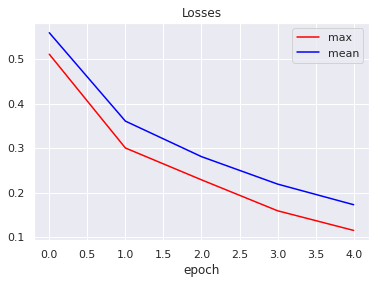

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 86.50
Лучшая accuracy для подхода mean: 86.70


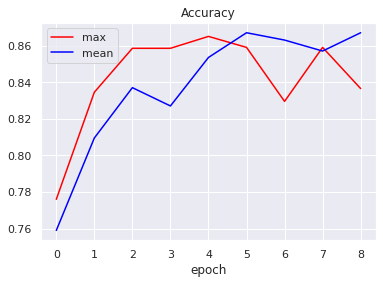

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()